## Problem Statement

<img src=https://www.matherhospital.org/wp-content/uploads/2017/09/brain-tumor-blog-photo.jpg width=500/>

A brain tumor is a mass or growth of abnormal cells in your brain.
Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). 

Our goal is to design a deep learning system based on vision transformers and compare it with other models using different metrics.

## Vision Transformers(ViT)

Vision Transformer (ViT) is the application of Transformer in the image domain with slight modification in the implementation in order to handle the different data modality. More specifically, a ViT uses different methods for tokenization and embedding. However, the generic architecture remains the same. An input image is split into a set of image patches, called visual tokens. The visual tokens are embedded into a set of encoded vectors of fixed dimension. The position of a patch in the image is embedded along with the encoded vector and fed into the transformer encoder network which is essentially the same as the one responsible for processing the text input. 

<img src=https://miro.medium.com/max/700/1*_c8SqxPMY_dsApyvDJ8HtA.gif width=600/>

There are multiple blocks in the ViT encoder and each block consists of three major processing elements: Layer Norm, Multi-head Attention Network (MSP) and Multi-Layer Perceptrons (MLP). Layer Norm keeps the training process on track and let model adapt to the variations among the training images. MSP is a network responsible for generation of attention maps from the given embedded visual tokens. These attention maps help network focus on most important regions in the image such as object(s). 

## Importing necessary libraries

In [ ]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 14.7 MB/s eta 0:00:00


## Setting up general parameters

## Data Loading, Preperation and Visualization

In [ ]:
folder_path = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [ ]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(253, 240, 240, 3) (253,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

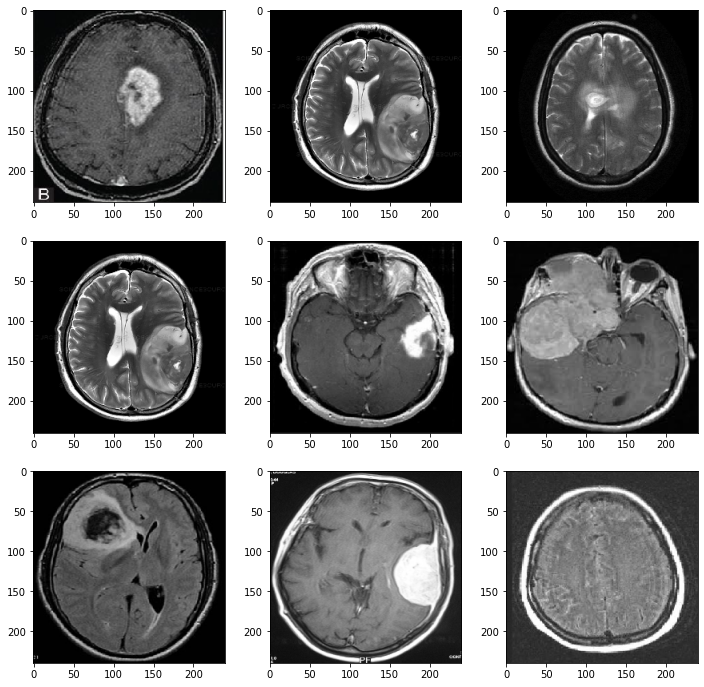

In [ ]:
plot_state('yes')

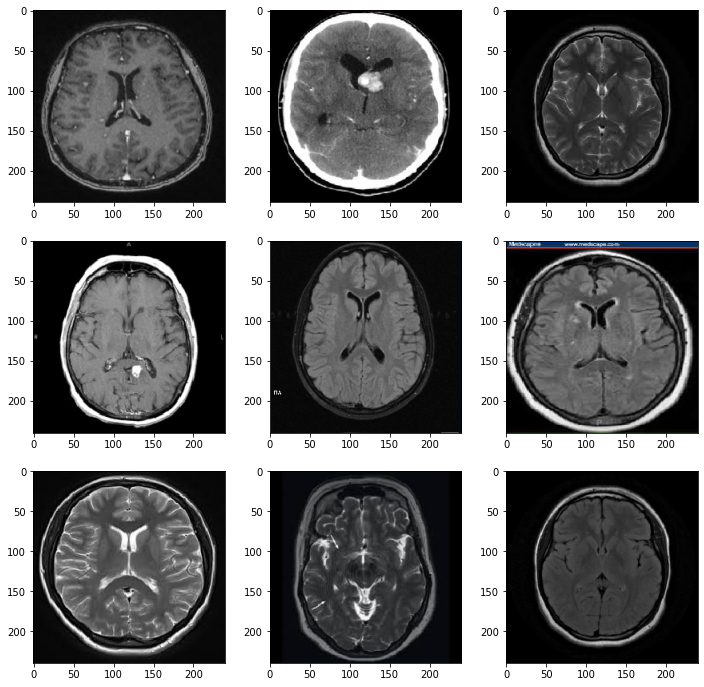

In [ ]:
plot_state("no")

## Modeling using Vision Transformers(ViT)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Multi-layer perceptron

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


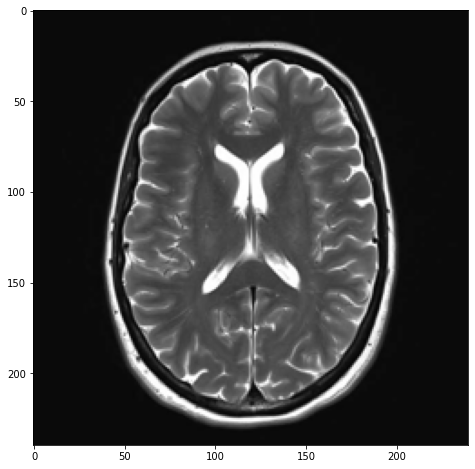

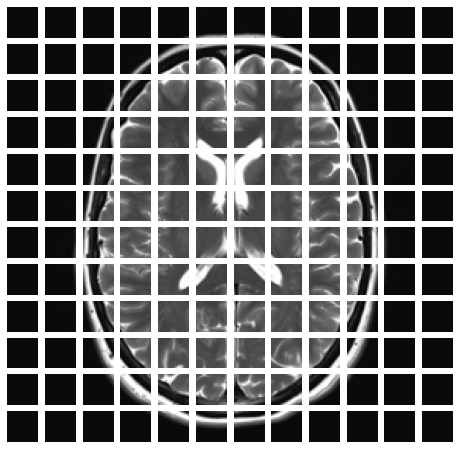

In [ ]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


## Creating the patch encoder
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building the ViT

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.



In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 1.9207 - accuracy: 0.4406 - top-5-accuracy: 1.0000 - val_loss: 13.0610 - val_accuracy: 0.6078 - val_top-5-accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 323ms/step - loss: 14.2622 - accuracy: 0.6139 - top-5-accuracy: 1.0000 - val_loss: 7.7356 - val_accuracy: 0.4706 - val_top-5-accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 298ms/step - loss: 5.7546 - accuracy: 0.5347 - top-5-accuracy: 1.0000 - val_loss: 3.5123 - val_accuracy: 0.6078 - val_top-5-accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 285ms/step - loss: 3.7645 - accuracy: 0.6139 - top-5-accuracy: 1.0000 - val_loss: 1.1974 - val_accuracy: 0.6863 - val_top-5-accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 273ms/step - loss: 1.1140 - accuracy: 0.6436 - top-5-accuracy: 1.0000 - val_loss: 2.2448 - val_accuracy: 0.3922 - val_top-5-accuracy: 1.0000
Epoch 6/100
1/1 [=======

## ViT model Evaluation

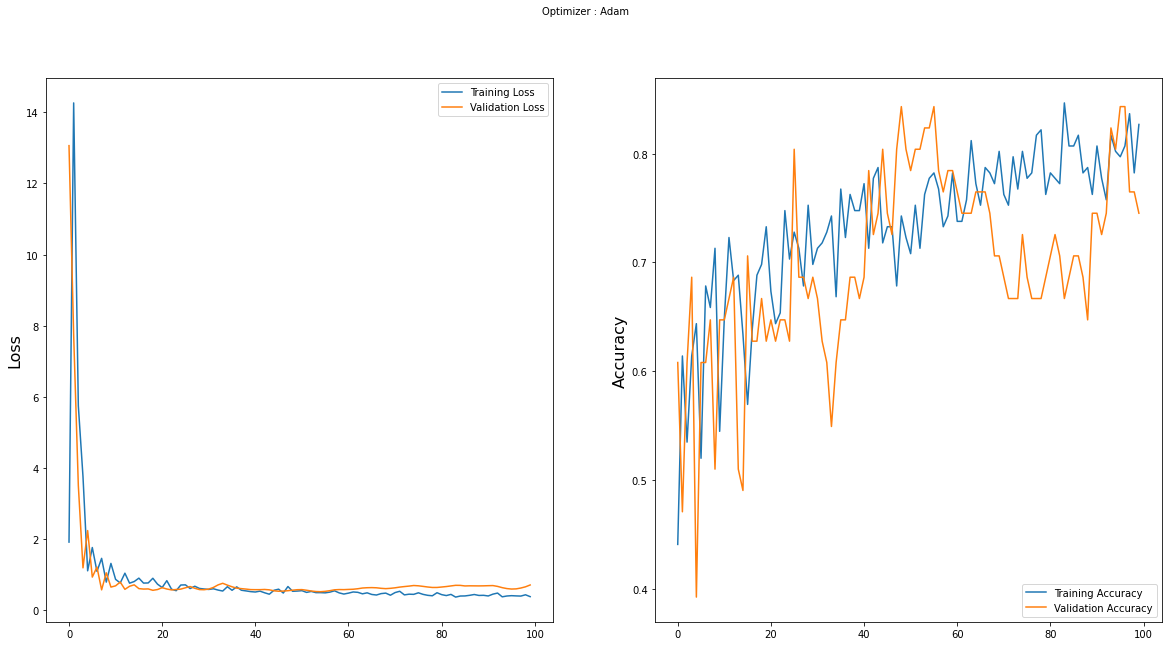

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()